# PCA for Algorithmic Trading: Eigen Portfolios

## Imports & Settings

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [48]:
sns.set_style('white')
np.random.seed(42)

## Eigenportfolios

Another application of PCA involves the covariance matrix of the normalized returns. The principal components of the correlation matrix capture most of the covariation among assets in descending order and are mutually uncorrelated. Moreover, we can use standardized the principal components as portfolio weights.

Let’s use the 30 largest stocks with data for the 2010-2018 period to facilitate the exposition:

### Data Preparation

In [49]:
import datetime
from pandas_datareader import data as pdr

stockList = ["AAPL", "ABT", "AMZN", "COST", "DE", "DG", "HD", "HON", "IHI", "MA", "MCD", "MCO", "MSFT", "NEE", "NVDA", "QQQ", "SOXX", "UL", "UNH", "V", "WMT"]
start_sp = datetime.datetime(2015,8,6)
end_sp = datetime.datetime(2021,1,8)
dfs = pdr.get_data_yahoo(stockList, start_sp, end_sp)['Adj Close'].pct_change().fillna(0)


We again winsorize and also normalize the returns:

In [50]:
returns = dfs
normed_returns = scale(returns
                       .clip(lower=returns.quantile(q=.025), 
                             upper=returns.quantile(q=.975), 
                             axis=1)
                      .apply(lambda x: x.sub(x.mean()).div(x.std())))

In [51]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1367 entries, 2015-08-06 to 2021-01-08
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1367 non-null   float64
 1   ABT     1367 non-null   float64
 2   AMZN    1367 non-null   float64
 3   COST    1367 non-null   float64
 4   DE      1367 non-null   float64
 5   DG      1367 non-null   float64
 6   HD      1367 non-null   float64
 7   HON     1367 non-null   float64
 8   IHI     1367 non-null   float64
 9   MA      1367 non-null   float64
 10  MCD     1367 non-null   float64
 11  MCO     1367 non-null   float64
 12  MSFT    1367 non-null   float64
 13  NEE     1367 non-null   float64
 14  NVDA    1367 non-null   float64
 15  QQQ     1367 non-null   float64
 16  SOXX    1367 non-null   float64
 17  UL      1367 non-null   float64
 18  UNH     1367 non-null   float64
 19  V       1367 non-null   float64
 20  WMT     1367 non-null   float64
dtypes: float64(21)
memo

In [52]:
cov = returns.cov()

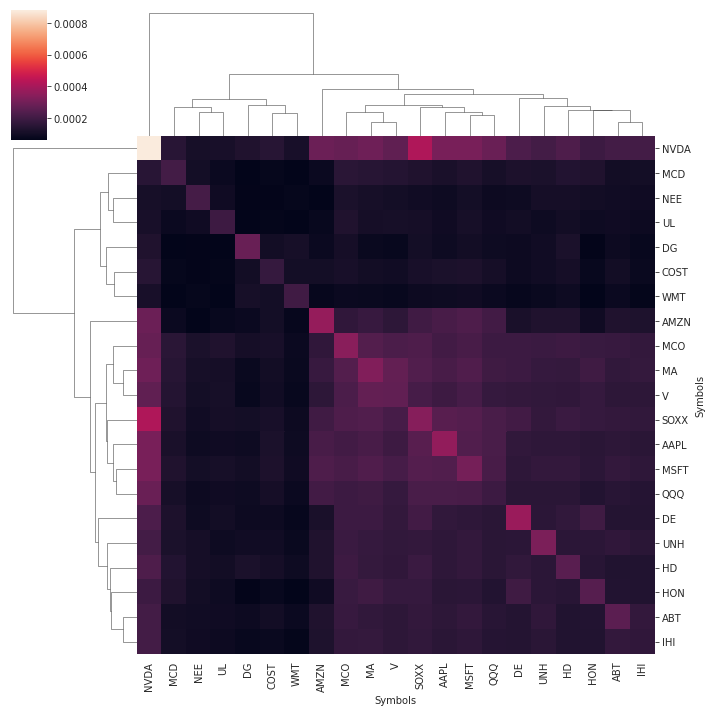

In [53]:
sns.clustermap(cov);

### Run PCA

After dropping assets and trading days as in the previous example, we are left with 23 assets and over 2,000 trading days. We estimate all principal components and find that the two largest explain 57.6% and 12.4% of the covariation, respectively:

In [54]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{:,.2%}'.format)

,Explained Variance
0,69.89%
1,10.30%
2,5.39%
3,2.83%
4,2.55%


### Create PF weights from principal components

Next, we select and normalize the four largest components so that they sum to 1 and we can use them as weights for portfolios that we can compare to an equal-weighted portfolio formed from all stocks::

In [55]:
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]

### Eigenportfolio Weights

The weights show distinct emphasis, e.g., portfolio 3 puts large weights on Mastercard and Visa, the two payment processors in the sampel whereas potfolio 2 has more exposure to some technology companies:

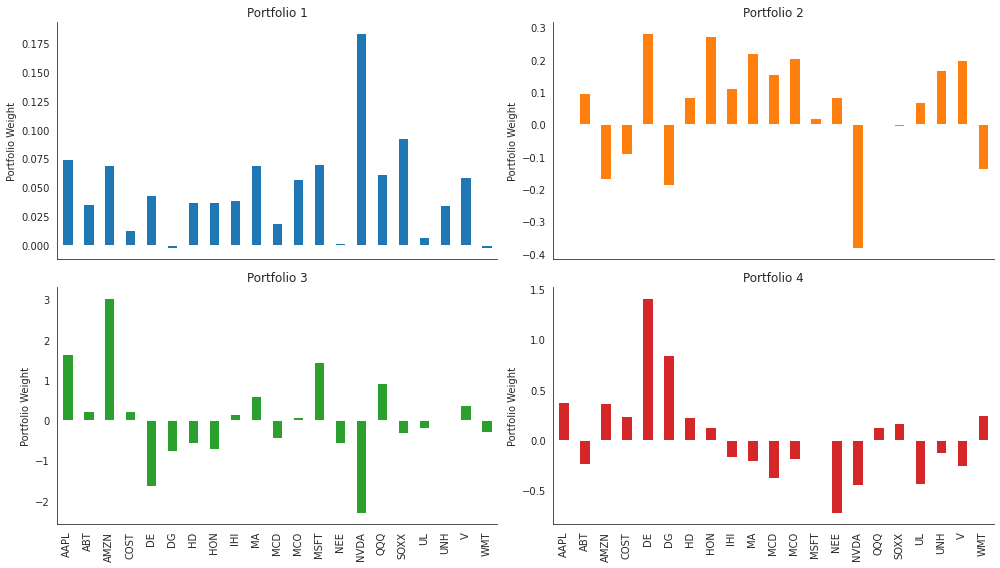

In [56]:
axes = eigen_portfolios.T.plot.bar(subplots=True,
                                   layout=(2, 2),
                                   figsize=(14, 8),
                                   legend=False)
for ax in axes.flatten():
    ax.set_ylabel('Portfolio Weight')
    ax.set_xlabel('')
sns.despine()
plt.tight_layout()

### Eigenportfolio Performance

When comparing the performance of each portfolio over the sample period to ‘the market’ consisting of our small sample, we find that portfolio 1 performs very similarly, whereas the other portfolios capture different return patterns.

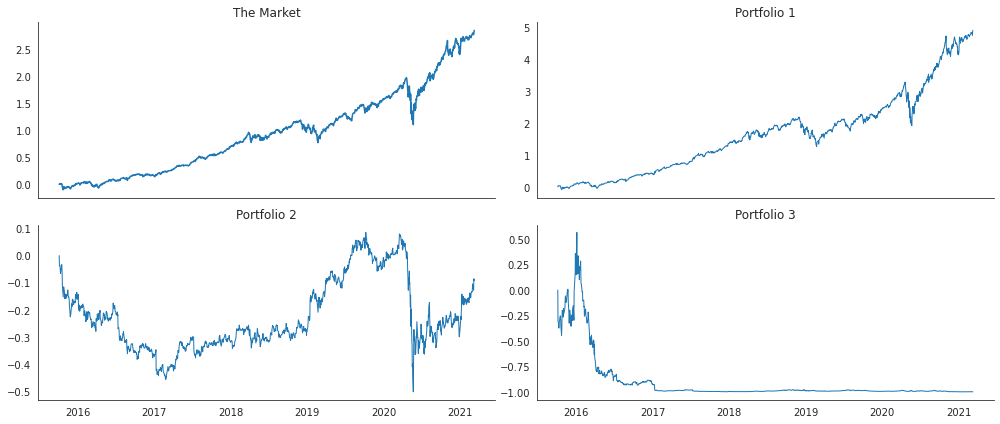

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0])
for i in range(3):
    rc = returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1)
    rc.plot(title=f'Portfolio {i+1}', ax=axes[i+1], lw=1, rot=0)

for i in range(4):
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout()

In [58]:
print(eigen_portfolios.iloc[0].sort_values(ascending=False))


Symbols
NVDA    0.183955
SOXX    0.093018
AAPL    0.074557
MSFT    0.070151
AMZN    0.069678
MA      0.069093
QQQ     0.061507
V       0.059091
MCO     0.056932
DE      0.043584
IHI     0.038895
HD      0.037236
HON     0.037185
ABT     0.035208
UNH     0.034435
MCD     0.019452
COST    0.012891
UL      0.007022
NEE     0.001358
DG     -0.002421
WMT    -0.002826
Name: Portfolio 1, dtype: float64
